# Clustering

Three different types of models were tested in this study. This notebook will provide a brief overview on how to use each one.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

In [2]:
# Load data - change the following lines depending on your data structure
frequency = np.load("Data/frequencies.npy")
raw_data = np.load("Data/Processed/shifted_signals.npy")
threshold_data = np.load("Data/Processed/threshold_signals.npy")
subtraction_data = np.load("Data/Processed/subtraction_signals.npy")
euclidean_umap = np.load("Data/Processed/euclidean_umap.npy")
cosine_umap = np.load("Data/Processed/cosine_umap.npy")

# Normalize data for appropriate comparison
raw_data /= np.max(raw_data, axis=1, keepdims=True)
threshold_data /= np.max(threshold_data, axis=1, keepdims=True)
subtraction_data /= np.max(subtraction_data, axis=1, keepdims=True)

## K-Means

In [3]:
from sklearn.cluster import KMeans
from src.models.kmeans import CustomKMeans

c:\Users\javia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Silhouette score

Firstly an example on how to calculate the silhouette score will be shown for each of the models. Next, the actual models reported in the thesis will be trained and their centroids shown.

100%|██████████| 9/9 [10:18<00:00, 68.74s/it]


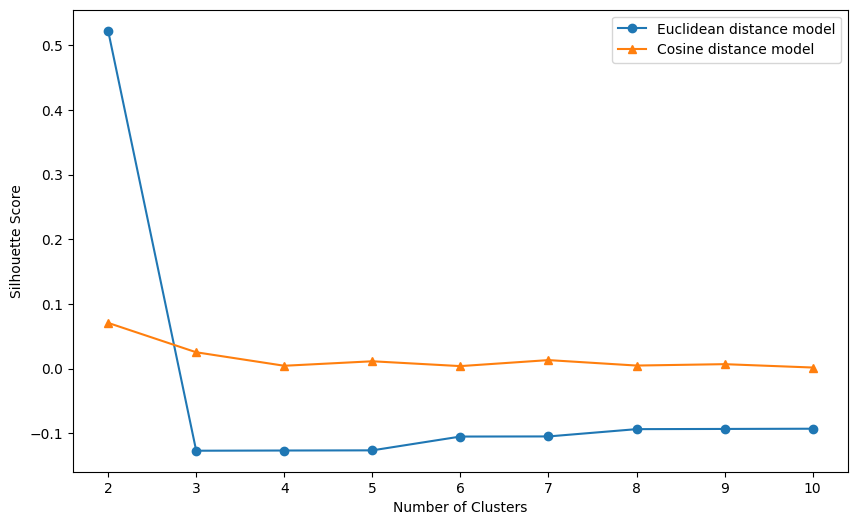

In [5]:
euclidean_s_score = []
cosine_s_score = []
for n_clusters in tqdm(range(2, 11)):
    # Euclidean distance
    euclidean_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    euclidean_labels = euclidean_kmeans.fit_predict(raw_data)
    
    # Cosine distance
    cosine_kmeans = CustomKMeans(n_clusters=n_clusters, distance_metric='cosine', random_state=42)
    cosine_labels = cosine_kmeans.fit_predict(raw_data)
    
    # Calculate and store the silhouette score
    euclidean_s_score.append(silhouette_score(raw_data, euclidean_labels, metric='euclidean'))
    cosine_s_score.append(silhouette_score(raw_data, cosine_labels, metric='cosine'))

# Plot the silhouette score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), euclidean_s_score, marker='o', label='Euclidean distance model')
plt.plot(range(2, 11), cosine_s_score, marker='^', label='Cosine distance model')
plt.legend()
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

### Euclidean-distance model

The model reported on the thesis uses the following parameters:
- n_clusters=8
- random_state=42

The data used for training is the max-normalized subtraction-filtered dataset, which is consistently reported in green throughout the different models.

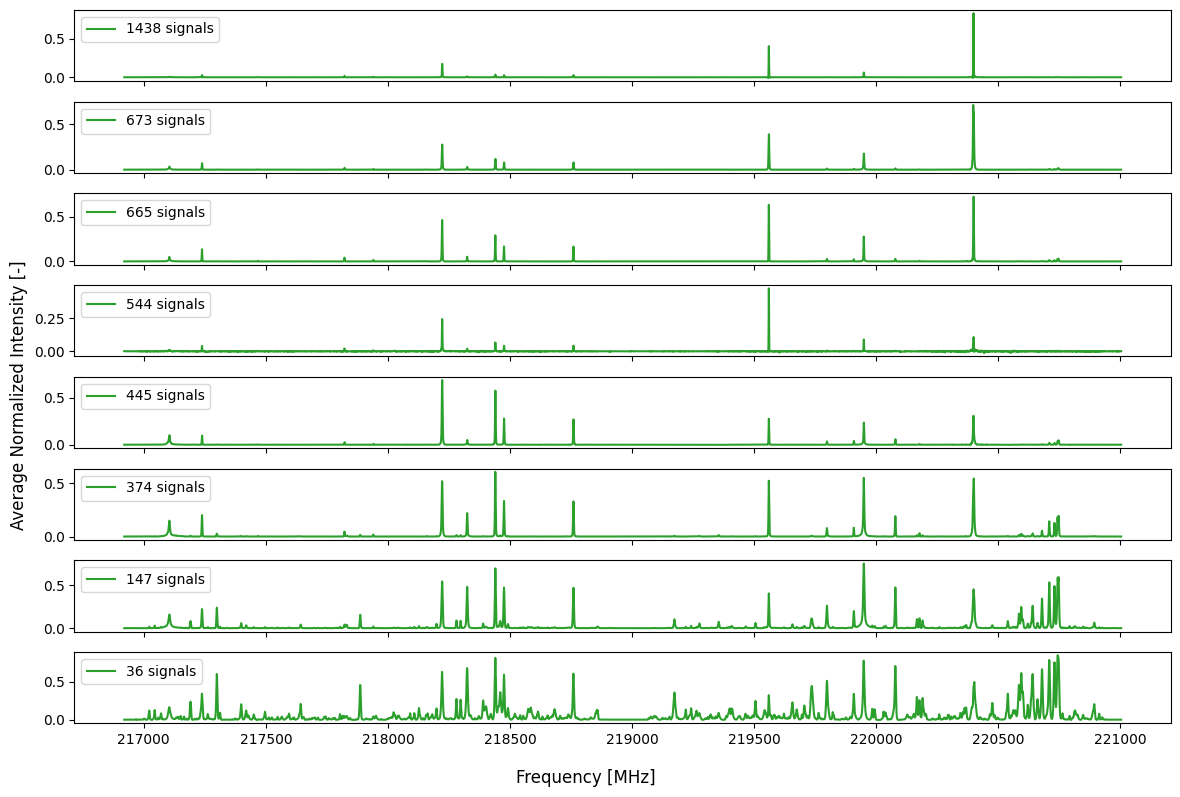

In [ ]:
# Train the model
model = KMeans(n_clusters=8, random_state=42).fit(subtraction_data)
labels = model.labels_

# Sort the labels based on cluster size
unique_labels, cluster_size = np.unique(labels, return_counts=True)
sorted_labels = np.zeros_like(labels)
for new_label, old_label in enumerate(unique_labels[np.argsort(cluster_size)[::-1]]):
    sorted_labels[labels == old_label] = new_label

# Plot the centroids
fig, ax = plt.subplots(8, 1, sharex=True, figsize=(12, 8))
for label in np.unique(sorted_labels):
    ax[label].plot(frequency, subtraction_data[sorted_labels == label].mean(axis=0), label=f"{sum(sorted_labels == label)} signals", color='tab:green')
    ax[label].legend(loc='upper left')
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
fig.tight_layout()
plt.show()

The cluster can then be evaluated using the within-cluster similarity and between-cluster similarity

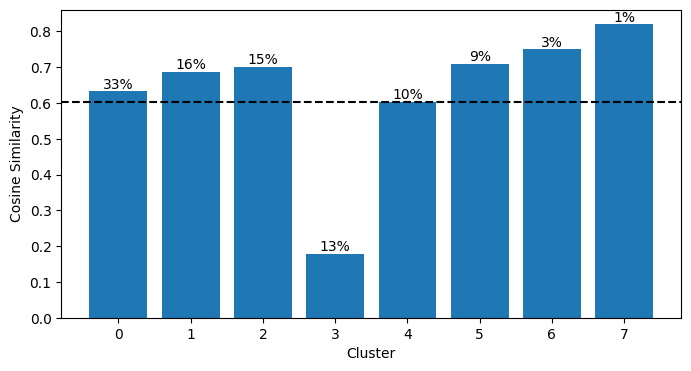

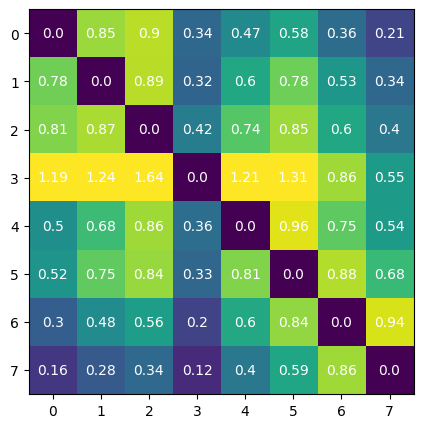

In [5]:
from src.features.evaluation import within_cluster_similarity, between_cluster_similarity

wcs = within_cluster_similarity(subtraction_data, sorted_labels, plot=True)
bcs = between_cluster_similarity(subtraction_data, sorted_labels, wcs=wcs, plot=True, text=True)

### Cosine-distance model

The parameters and procedures used for the training of this model are the same as for the previous one. This model, however, takes much longer to train, so the number of initializations is limited (n_init=5 takes slightly more than 1 minute to train). This limitation, however, makes the model output slightly different clusters every time the cell is executed. The results discussed in the thesis are therefore not guaranteed to be the same that one will obtain by running the cell below.

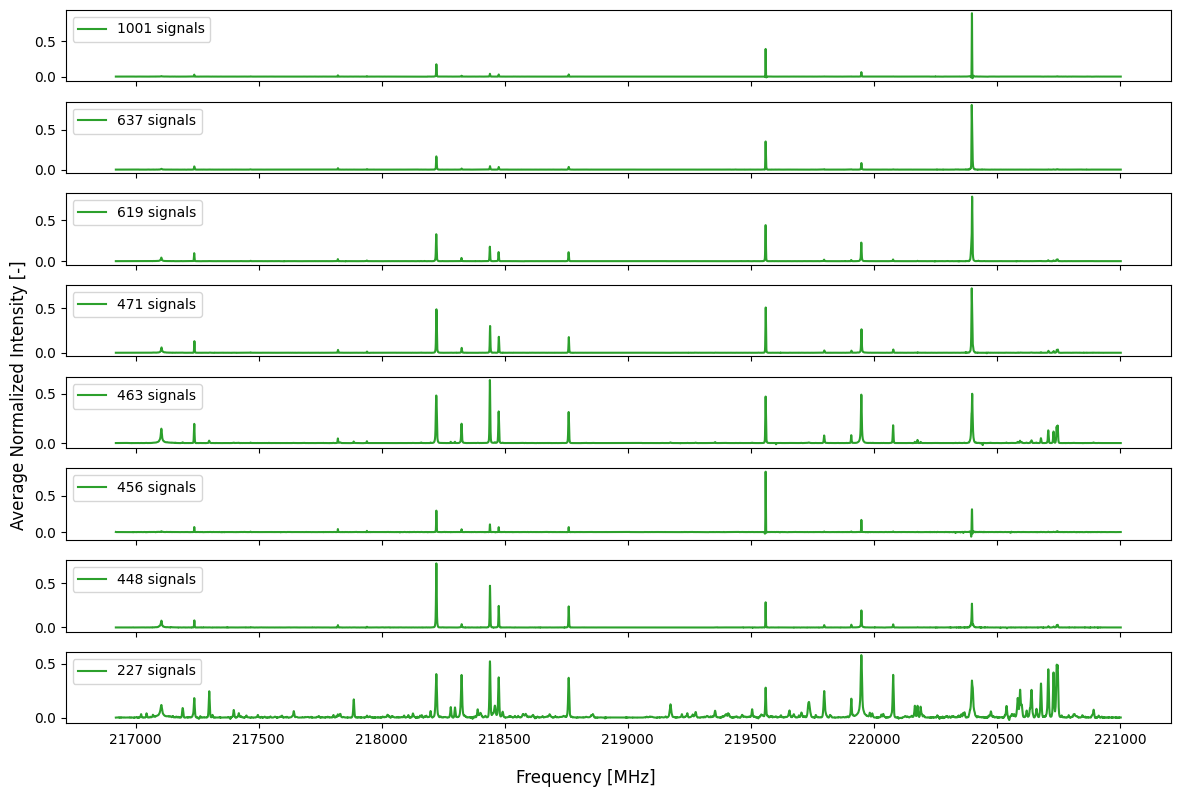

In [8]:
# Train the model
model = CustomKMeans(n_clusters=8, random_state=42).fit(subtraction_data)
labels = model.labels_

# Sort the labels based on cluster size
unique_labels, cluster_size = np.unique(labels, return_counts=True)
sorted_labels = np.zeros_like(labels)
for new_label, old_label in enumerate(unique_labels[np.argsort(cluster_size)[::-1]]):
    sorted_labels[labels == old_label] = new_label

# Plot the centroids
fig, ax = plt.subplots(8, 1, sharex=True, figsize=(12, 8))
for label in np.unique(sorted_labels):
    ax[label].plot(frequency, subtraction_data[sorted_labels == label].mean(axis=0), label=f"{sum(sorted_labels == label)} signals", color='tab:green')
    ax[label].legend(loc='upper left')
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
fig.tight_layout()
plt.show()

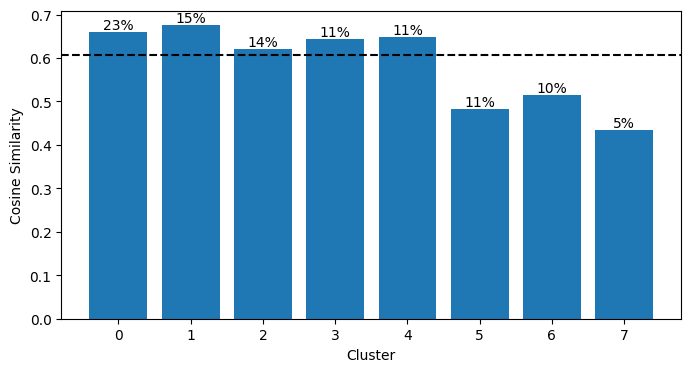

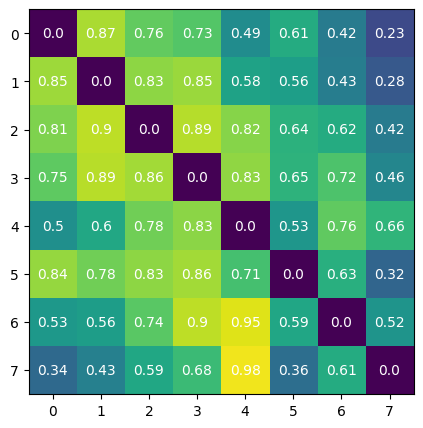

In [10]:
# Evaluate the clustering
wcs_cosine = within_cluster_similarity(subtraction_data, sorted_labels, plot=True)
bcs_cosine = between_cluster_similarity(subtraction_data, sorted_labels, wcs=wcs_cosine, plot=True, text=True)

### Masking major peaks

The following cell outlines the procedure to follow when training a model on masked data.

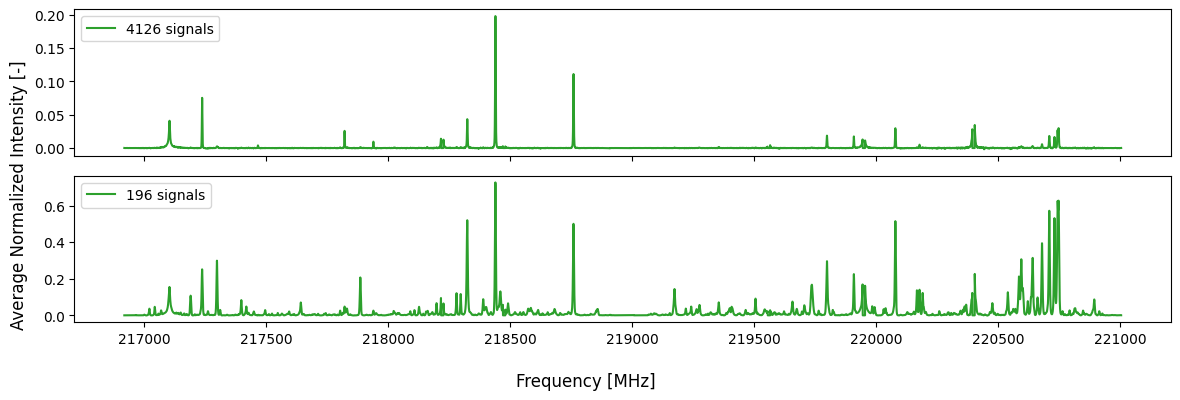

In [11]:
# Define central locations of the areas to mask and mask width
peaks = [
    218222.192,  # H2CO
    218475.632,  # H2CO
    220398.684,  # 13CO(2-1)
    219949.433,  # SO(5,6-4,5)
    219560.358   # C18O(2-1)
]

width = 50  # number of channels to mask

# Define the mask
mask = np.zeros(raw_data.shape[1], dtype=bool)
for peak in peaks:
    peak_idx = np.argmin(np.abs(frequency - peak))
    mask[peak_idx - width // 2 : peak_idx + width // 2] = True

# Mask the data
masked_data = np.copy(subtraction_data)
masked_data[:, mask] = 0

# Train the model on masked data
model = KMeans(n_clusters=2, random_state=42).fit(masked_data)

# Plot centroids
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
ax[0].plot(frequency, masked_data[model.labels_ == 0].mean(axis=0), label=f"{sum(model.labels_ == 0)} signals", color='tab:green')
ax[0].legend(loc='upper left')
ax[1].plot(frequency, masked_data[model.labels_ == 1].mean(axis=0), label=f"{sum(model.labels_ == 1)} signals", color='tab:green')
ax[1].legend(loc='upper left')
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
fig.tight_layout()
plt.show()

## Gaussian Mixture Model (GMM)

This model requires the use of dimensionality-reduction methods. PCA can also be used, however, only UMAP will be portrayed in this notebook as it was the most successful iteration of the model.

Since the only relevant parameter is the relative distance of a signal to its neighbors and not its location in the projection, the actual projection may differ from the one reported in the thesis. If you wish to have access to the UMAP projections I used in the thesis, email me.

In [19]:
from sklearn.mixture import GaussianMixture

In [14]:
## Reduce the data - comment the next 3 lines if the data is already stored
# from umap import UMAP
# euclidean_umap = UMAP(n_components=2, metric='euclidean', random_state=42).fit_transform(subtraction_data)
# cosine_umap = UMAP(n_components=2, metric='cosine', random_state=42).fit_transform(subtraction_data)

## Load the data - uncomment the next 2 lines if the data is already stored
euclidean_umap = np.load("Data/Processed/euclidean_umap.npy")
cosine_umap = np.load("Data/Processed/cosine_umap.npy")

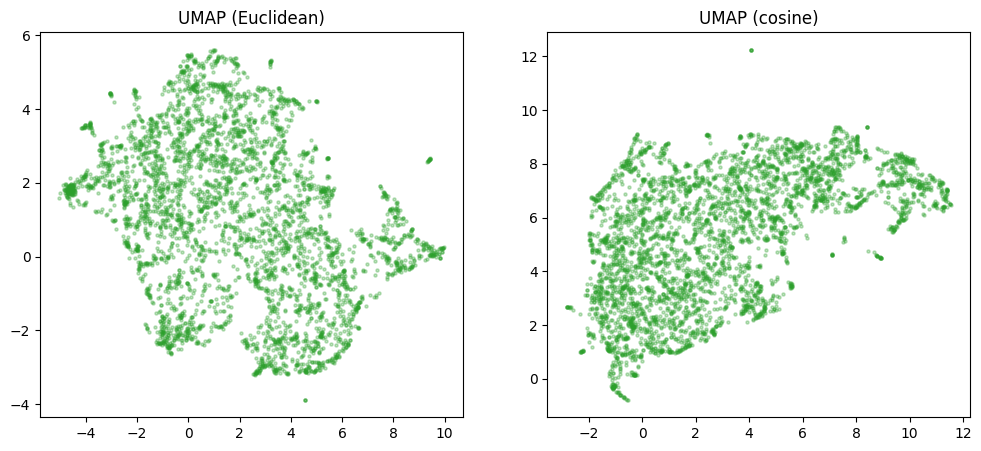

In [15]:
# Check the data was appropriately reduced
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(euclidean_umap[:, 0], euclidean_umap[:, 1], s=5, alpha=0.3, color='tab:green')
ax[0].set_title("UMAP (Euclidean)")
ax[1].scatter(cosine_umap[:, 0], cosine_umap[:, 1], s=5, alpha=0.3, color='tab:green')
ax[1].set_title("UMAP (cosine)")
plt.show()

### Small clusters

This section may not seem as relevant, however, please run the following cells to obtain the same clusters found in the thesis. The model may identify different clusters if the data differs even slightly.

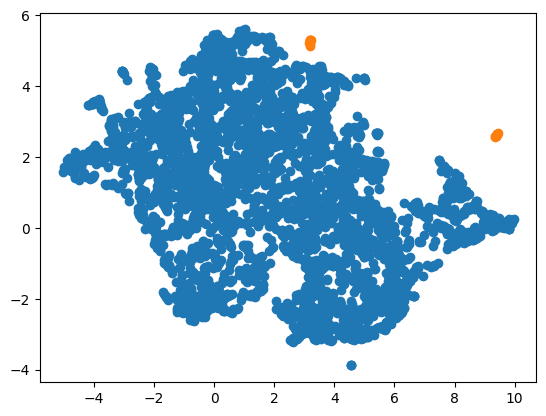

In [26]:
# Identify the small clusters
m0 = (euclidean_umap[:, 0] > 8.5) * (euclidean_umap[:, 1] > 1)  # Broad-peak cluster
m1 = (euclidean_umap[:, 0] > 2.8) * (euclidean_umap[:, 1] > 4.8)  # Other small cluster
mask = m0 + m1

# Plot the projections to ensure the clusters are correctly identified
plt.scatter(euclidean_umap[~mask][:, 0], euclidean_umap[~mask][:, 1])
plt.scatter(euclidean_umap[mask][:, 0], euclidean_umap[mask][:, 1])
plt.show()

### Model training

Training the model works the same way for both projections, so only the Euclidean-distance projection will be demonstrated.

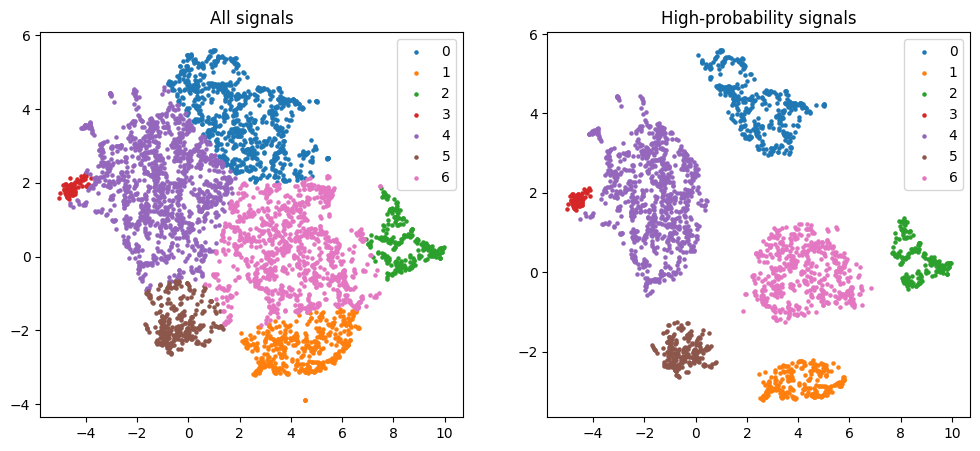

In [24]:
# Train the model
gmm = GaussianMixture(n_components=7, random_state=42).fit(euclidean_umap[~mask])

# Retrieve labels and probabilities
labels = gmm.predict(euclidean_umap[~mask])
probability_matrix = gmm.predict_proba(euclidean_umap[~mask])

# Plot the entire clusters and the high-probability clusters
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for label in np.unique(labels):
    ax[0].scatter(euclidean_umap[~mask][labels == label][:, 0], euclidean_umap[~mask][labels == label][:, 1], s=5, label=f"{label}")
    ax[1].scatter(euclidean_umap[~mask][(labels == label) & (probability_matrix.max(axis=1) > 0.9)][:, 0], euclidean_umap[~mask][(labels == label) & (probability_matrix.max(axis=1) > 0.9)][:, 1], s=5, label=f"{label}")
ax[0].legend()
ax[1].legend()
ax[0].set_title("All signals")
ax[1].set_title("High-probability signals")
plt.show()

Alternatively, the training and plotting can be directly handled by the plot_kde_gmm function in src.models.gmm. In this case, however, the label assignments will most likley differ when looking at all signals and only those clustered with high confidence.

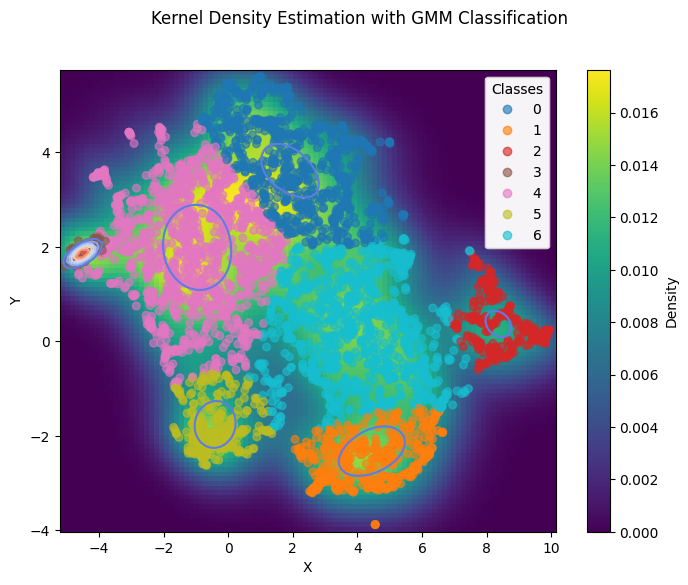

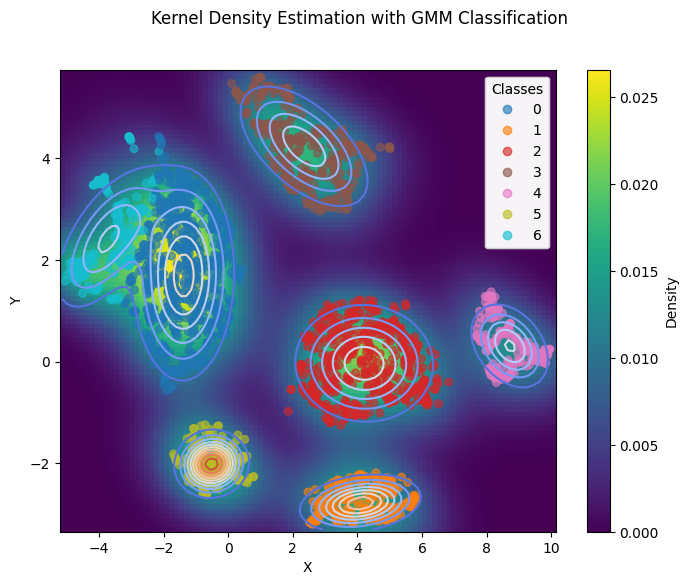

In [25]:
from src.models.gmm import plot_kde_gmm

# Plot the KDE and GMM contours for high-probability signals
gmm = plot_kde_gmm(euclidean_umap[~mask], n_components=7)
probability_matrix = gmm.predict_proba(euclidean_umap[~mask])

# Plot only high-probability signals
gmm_high_prob = plot_kde_gmm(euclidean_umap[~mask][probability_matrix.max(axis=1) > 0.9], n_components=7)

The first approach is recommended since, as seen in the above examples, re-training the data may lead to some signals being re-assigned to different clusters if the two clusters in question are very close together.

Once more, the outputs can be evaluated in the same manner as with the K-means. Note that the next cell is a repetition of the one two cells above, done to correct the miss-classification of the high-confidence signals.

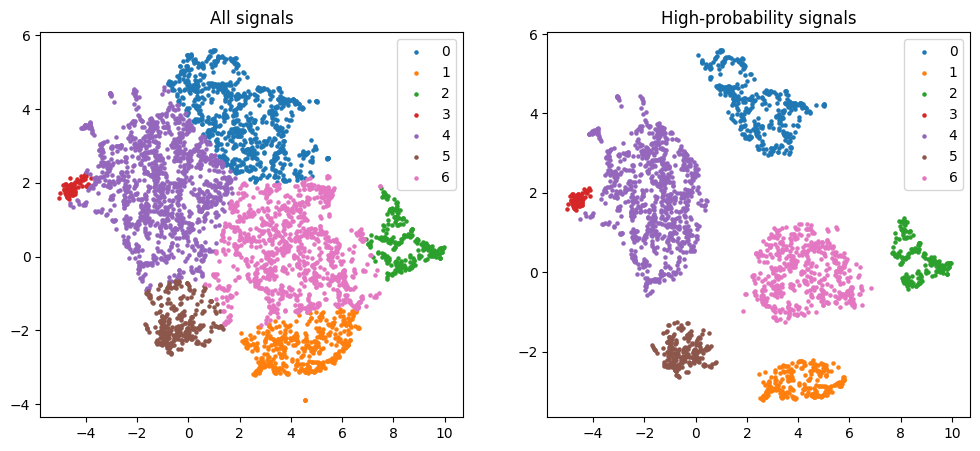

In [36]:
# Train the model
gmm = GaussianMixture(n_components=7, random_state=42).fit(euclidean_umap[~mask])

# Retrieve labels and probabilities
labels = gmm.predict(euclidean_umap[~mask])
probability_matrix = gmm.predict_proba(euclidean_umap[~mask])

# Plot the entire clusters and the high-probability clusters
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for label in np.unique(labels):
    ax[0].scatter(euclidean_umap[~mask][labels == label][:, 0], euclidean_umap[~mask][labels == label][:, 1], s=5, label=f"{label}")
    ax[1].scatter(euclidean_umap[~mask][(labels == label) & (probability_matrix.max(axis=1) > 0.9)][:, 0], euclidean_umap[~mask][(labels == label) & (probability_matrix.max(axis=1) > 0.9)][:, 1], s=5, label=f"{label}")
ax[0].legend()
ax[1].legend()
ax[0].set_title("All signals")
ax[1].set_title("High-probability signals")
plt.show()

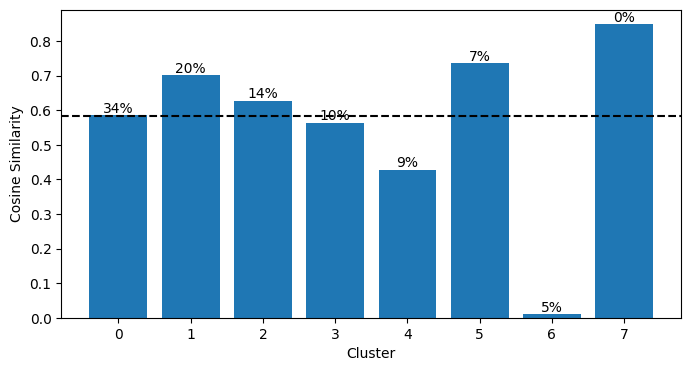

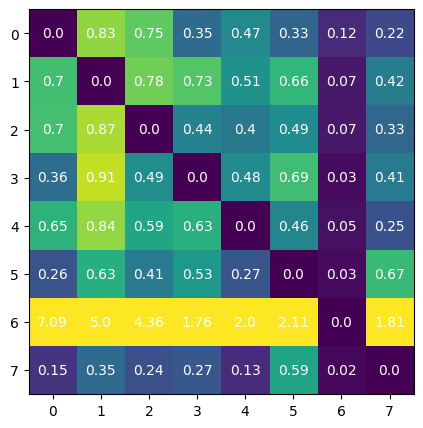

In [37]:
# Add small clusters to the mix
hp_labels = np.append(labels[probability_matrix.max(axis=1) > 0.9], 7 * np.ones(sum(m0)))
hp_signals = np.vstack((subtraction_data[~mask][probability_matrix.max(axis=1) > 0.9], subtraction_data[m0]))

# Plot the evaluation metrics
wcs = within_cluster_similarity(hp_signals, hp_labels, plot=True)
bcs = between_cluster_similarity(hp_signals, hp_labels, wcs=wcs, plot=True, text=True)

Clusters with a low WCS can be inspected using the procedure outlined in the following cell.

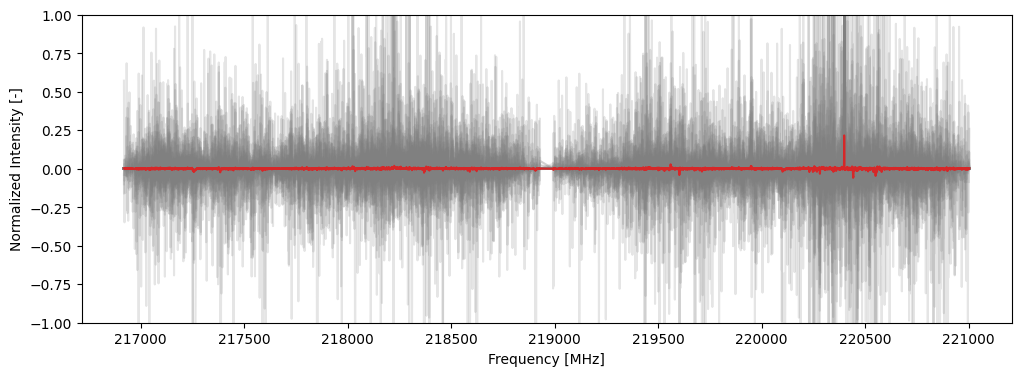

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(frequency, subtraction_data[~mask][labels==3].T, color='grey', alpha=0.2)
plt.plot(frequency, subtraction_data[~mask][labels==3].mean(axis=0), color='tab:red')
plt.ylim(-1, 1)  # Set y-axis limits for better visualization (some absorption features go below -1)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Intensity [-]")
plt.show()

Finally, the signals in between two clusters can be analysed as follows. 

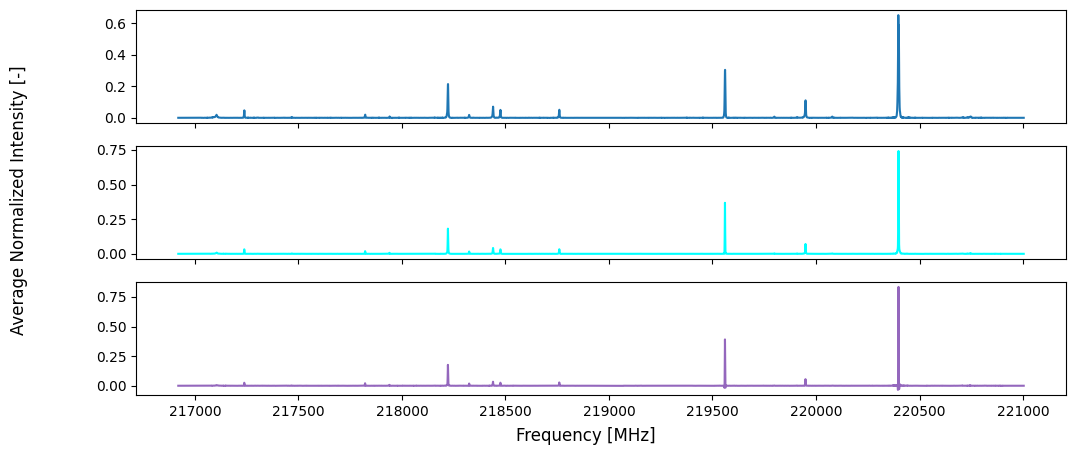

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 5))

ax[0].plot(frequency, hp_signals[hp_labels == 0].mean(axis=0), color='tab:blue')
ax[2].plot(frequency, hp_signals[hp_labels == 4].mean(axis=0), color='tab:purple')
ax[1].plot(frequency, subtraction_data[~mask][probability_matrix[:, 0] + probability_matrix[:, 4] > 0.9].mean(axis=0), color='cyan')

fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
plt.show()

## Agglomerative clustering

Two types of agglomerative clustering models were tested in the thesis. The first is a model that uses the concept of neighborhood and directed graphs, inspired by Zhang et. al. (2012). The resulting model is accessible through "src.models.agglomerative.CustomAgglomerativeClustering". The second model is a conventional agglomerative clustering model, provided by the sklearn library.

### Neighborhood-based model

There are 2 main parameters that need to be determined for the neighborhood-based agglomerative clustering model:
- k0_neighbors: number of neighbors to consider for the initial clustering
- k_neighbors: number of neighbors to consider for the subsequent merging process

Instead of considering each signal an independent cluster at the start, the initial clusters are determined based on a k0-NN graph. Consider the case where k0=1 and we have 5 points. Assume the following neighborhood graph:
- A -> B
- B -> C
- C -> B
- D -> E
- E -> D

In this scenario, 2 initial clusters would be formed, one consisting of A, B and C, and another one with D and E.

In the given dataset, k0 must be set to either 1 when using the entire signals or 2 when using the UMAP projections, as increasing its value will result in very large clusters being initially formed. The first iteration of the model was performed on the raw signals as follows:

In [7]:
from src.models.agglomerative import CustomAgglomerativeClustering

model = CustomAgglomerativeClustering(k0_neighbors=1, k_neighbors=25).fit(subtraction_data)
print(np.unique(model.labels_, return_counts=True))

Merging clusters: 100%|██████████| 612/612 [02:57<00:00,  3.45it/s]

(array([0]), array([4322]))


The size of the largest cluster throughout the merging process can be accessed through the model.label_history variable

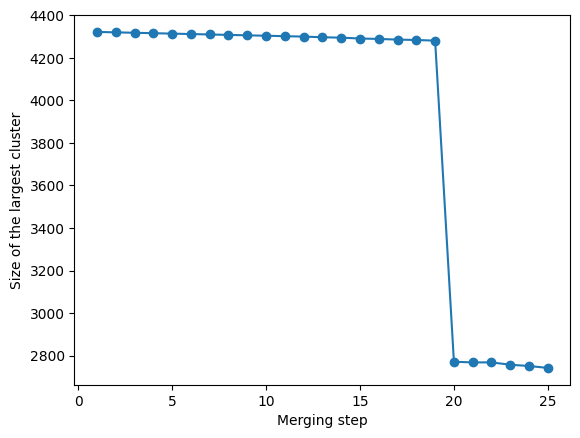

In [9]:
# Access the size of the largest cluster throughout the last 25 merging steps
largest_clsuter_size = [max(np.unique(model.label_history[-i], return_counts=True)[1]) for i in range(1, 26)]

# Plot the results
plt.plot(range(1, 26), largest_clsuter_size, marker='o')
plt.xlabel("Merging step")
plt.ylabel("Size of the largest cluster")
plt.show()

This clearly shows that two large clusters were merged at the 19th final step. To identify which clusters were merged, we can access the previous step's label assignment.

Clusters merged at step 19: 19 (size 2771) and 18 (size 1510)


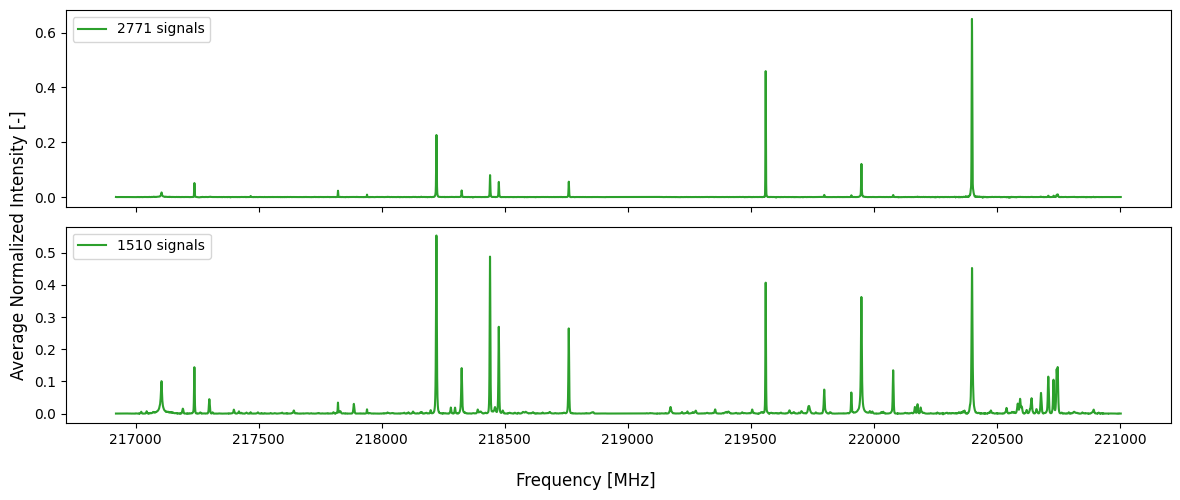

In [19]:
# Identify the clusters being merged
labels = np.unique(model.label_history[-20])

# Identify their sizes
cluster_a, cluster_b = labels[-1], labels[-2]
size_a = sum(np.array(model.label_history[-20] == cluster_a))
size_b = sum(np.array(model.label_history[-20] == cluster_b))

# Print results
print(f"Clusters merged at step 19: {labels[-1]} (size {size_a}) and {labels[-2]} (size {size_b})")

# Plot the two clusters
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
ax[0].plot(frequency, subtraction_data[np.array(model.label_history[-20]) == cluster_a].mean(axis=0), color='tab:green', label=f'{size_a} signals')
ax[0].legend(loc='upper left')
ax[1].plot(frequency, subtraction_data[np.array(model.label_history[-20]) == cluster_b].mean(axis=0), color='tab:green', label=f'{size_b} signals')
ax[1].legend(loc='upper left')
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
fig.tight_layout()
plt.show()

The same procedure can be applied when using the UMAP-reduced dataset, although the distance metric must be changed to "euclidean".

Merging clusters:  97%|█████████▋| 275/283 [00:48<00:01,  5.72it/s]


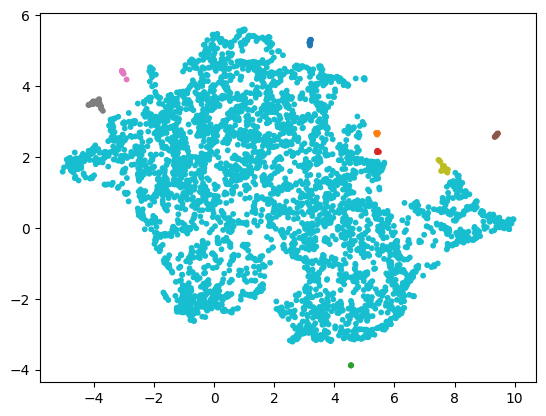

In [24]:
model = CustomAgglomerativeClustering(k0_neighbors=2, k_neighbors=12, distance_metric='euclidean').fit(euclidean_umap)

plt.scatter(euclidean_umap[:, 0], euclidean_umap[:, 1], c=model.labels_, s=10, cmap='tab10')
plt.show()

Similarly, this cluster can be broken down by accessing model.label_history

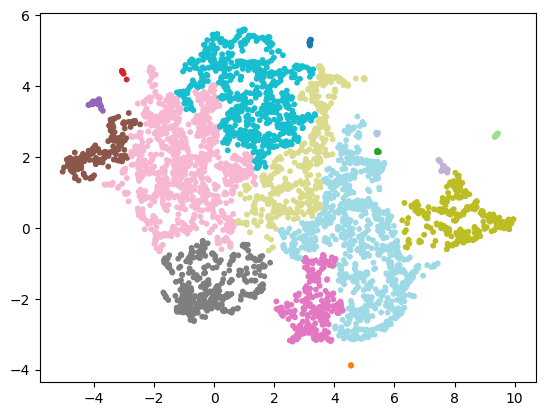

In [25]:
plt.scatter(euclidean_umap[:, 0], euclidean_umap[:, 1], c=model.label_history[-8], s=10, cmap='tab20')
plt.show()

### Conventional agglomerative clustering

The conventional model is much more straight-forward to implement as it does not use any custom parameters such as "label_history". The Euclidean-distance models will be now demonstrated.

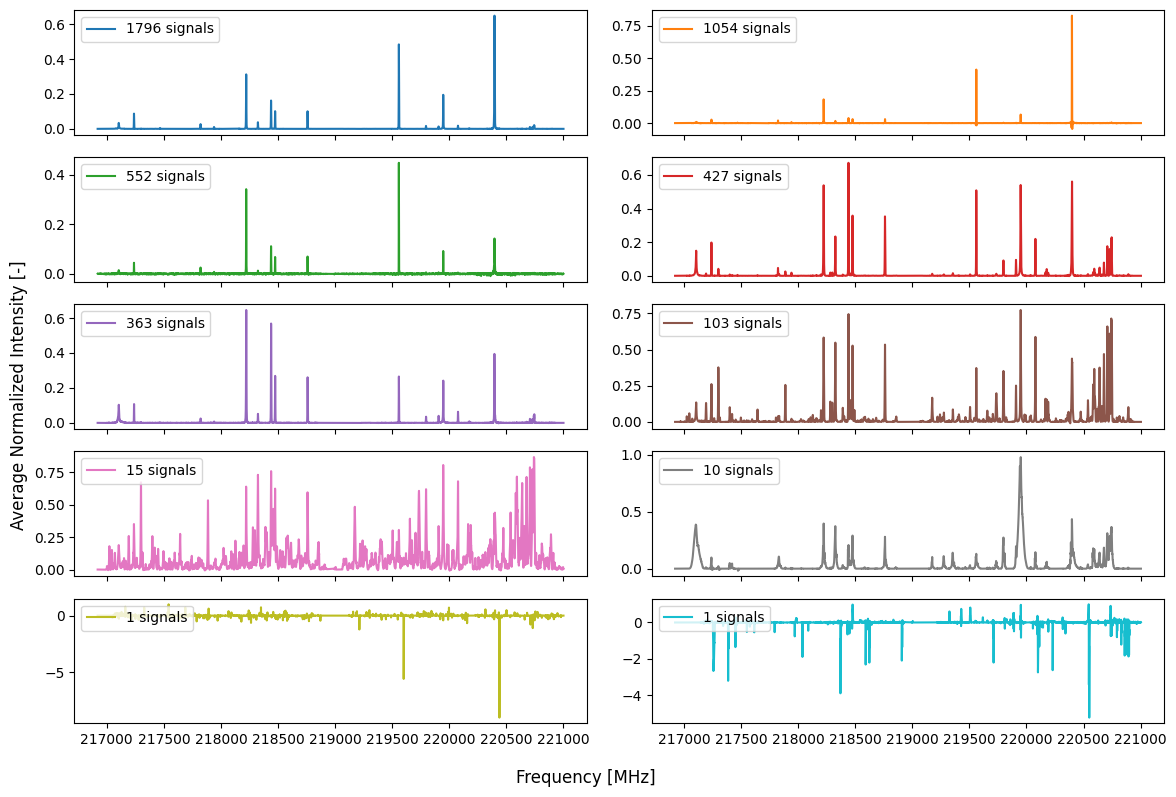

In [3]:
from sklearn.cluster import AgglomerativeClustering

# Default distance metric and linkage are "euclidean" and "ward"
# Change these parameters to "cosine" and "average" for cosine-distance model
model = AgglomerativeClustering(n_clusters=10).fit(subtraction_data)
labels = model.labels_

# Sort the labels based on cluster size
unique_labels, cluster_size = np.unique(labels, return_counts=True)
sorted_labels = np.zeros_like(labels)
for new_label, old_label in enumerate(unique_labels[np.argsort(cluster_size)[::-1]]):
    sorted_labels[labels == old_label] = new_label

# Plot the centroids
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(12, 8))
ax = ax.flatten()
for label in np.unique(sorted_labels):
    ax[label].plot(frequency, subtraction_data[sorted_labels == label].mean(axis=0), label=f"{sum(sorted_labels == label)} signals", color=plt.get_cmap('tab10').colors[label])
    ax[label].legend(loc='upper left')
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Average Normalized Intensity [-]")
fig.tight_layout()
plt.show()

To investigate the SNR of the signals in each cluster, seaborn's KDE plot was used.

In [4]:
# Import residual for SNR calculation
residual = np.load("Data/Processed/shifted_residual.npy")

# Import raw date without normalization for correct calculation
raw_data = np.load("Data/Processed/shifted_signals.npy")

# Calculate SNR for each signal
snr = 10 * np.log10(np.mean(raw_data**2, axis=1) / np.mean(residual**2, axis=1))

C:\Users\javia\AppData\Local\Temp\ipykernel_3156\731026428.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(snr[sorted_labels == label], ax=ax, label=label)
C:\Users\javia\AppData\Local\Temp\ipykernel_3156\731026428.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(snr[sorted_labels == label], ax=ax, label=label)


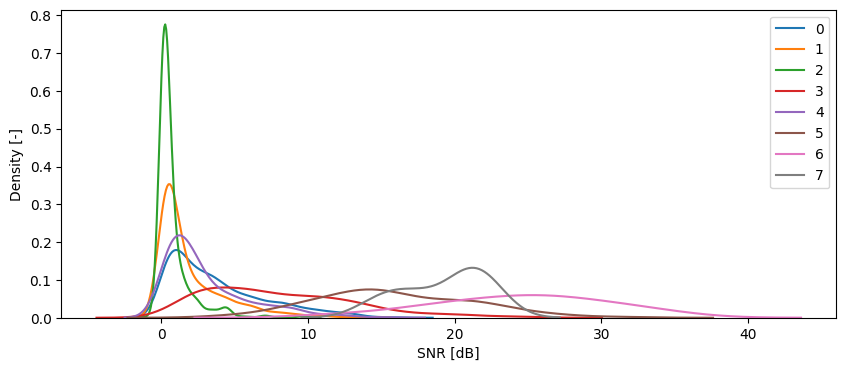

In [5]:
from seaborn import kdeplot

fig, ax = plt.subplots(figsize=(10, 4))
for label in np.unique(sorted_labels):
    kdeplot(snr[sorted_labels == label], ax=ax, label=label)
ax.legend()
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Density [-]")
plt.show()

Finally, delete the signals from cluster with WCS < 0.4 that have a SNR < 1dB. In this case, the only cluster that needs to be trimmed is cluster 2.

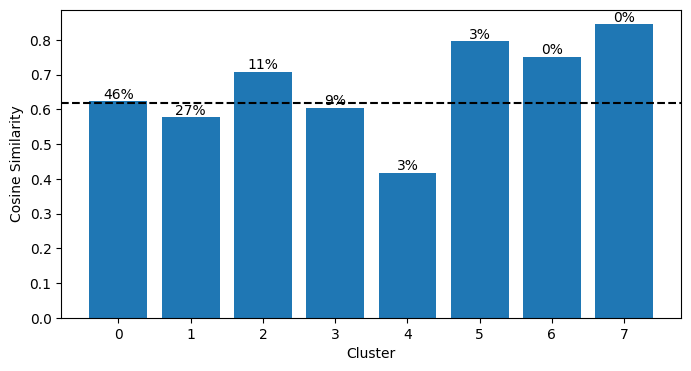

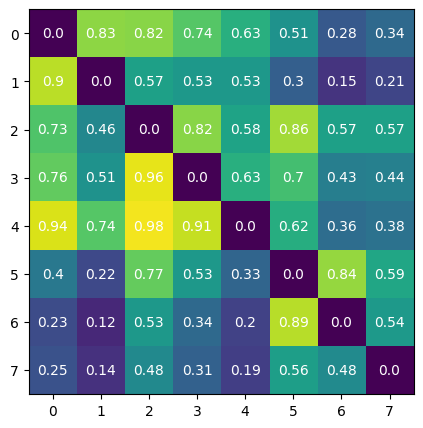

Mean BCS/WCS ratio: 0.294


In [6]:
from src.features.evaluation import within_cluster_similarity, between_cluster_similarity

# Identify signals from cluster 2 with SNR < 1dB
mask = (sorted_labels == 2) * (snr < 1)

# Add to the mask the 1-signal clusters
mask += (sorted_labels >= 8)

# Calculate WCS and BCS without the low-SNR signals
wcs = within_cluster_similarity(subtraction_data[~mask], sorted_labels[~mask], plot=True)
bcs = between_cluster_similarity(subtraction_data[~mask], sorted_labels[~mask], wcs=wcs, plot=True, text=True)
print(f'Mean BCS/WCS ratio: {np.mean(bcs * bcs.T):.3f}')